In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import sys
sys.path.append('../')

from algorithms.Vanilla_LSTM import Vanilla_LSTM
from data_processing.process_data import process_data

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from feature_engine.selection import SmartCorrelatedSelection, DropConstantFeatures, DropDuplicateFeatures, DropFeatures, DropCorrelatedFeatures, SelectBySingleFeaturePerformance, RecursiveFeatureAddition
from feature_engine.outliers import Winsorizer

## Data loading

In [2]:
datasets = process_data()

valve1_X =  datasets["valve1_X"]
valve1_y = datasets["valve1_y"]
valve2_X = datasets["valve2_X"]
valve2_y = datasets["valve2_y"]
other_anomaly_X = datasets["other_anomaly_X"]
other_anomaly_y = datasets["other_anomaly_y"]

In [3]:
# hyperparameters selection
N_STEPS = 5
EPOCHS = 10
BATCH_SIZE = 32
VAL_SPLIT = 0.2
Q = 0.99 # quantile for upper control limit (UCL) selection
PARAMS = [N_STEPS, EPOCHS, BATCH_SIZE, VAL_SPLIT]
model = Vanilla_LSTM(PARAMS)

In [4]:
def test_train_split(df_X, df_y):
    size_train = int(df_X.shape[0]*0.8)
    size_test = df_X.shape[0] - size_train
    x_train = df_X[:size_train]
    y_train = df_y[:size_train].anomaly
    x_test = df_X[-size_test:]
    y_test = df_y[-size_test:].anomaly
    return x_train, y_train, x_test, y_test

In [5]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

## Base models
#### Test model for valve 1

In [6]:
x_train, y_train, x_test, y_test = test_train_split(valve1_X, valve1_y)
x_train_steps, y_train_steps = split_sequences(np.array([row.values for i, row in x_train.iterrows()]), N_STEPS)
x_test_steps, y_test_steps = split_sequences(np.array([row.values for i, row in x_test.iterrows()]), N_STEPS)

model.fit(x_train_steps,y_train_steps)

# results predicting
residuals_train = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
UCL = residuals_train.quantile(Q)

454/454 [==============================] - 1s 2ms/step


In [7]:
# results predicting
lstm_residuals = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
yhat_train = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=x_train[N_STEPS:].index).fillna(0)

lstm_residuals = pd.DataFrame(y_test_steps - model.predict(x_test_steps)).abs().sum(axis=1)
yhat_test = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=x_test[N_STEPS:].index).fillna(0)

114/114 [==============================] - 0s 2ms/step


In [8]:
print('Training accuracy {:.4f}'.format(accuracy_score(y_train[N_STEPS:],yhat_train)))
print('Testing accuracy {:.4f}'.format(accuracy_score(y_test[N_STEPS:],yhat_test)))

Training accuracy 0.6467
Testing accuracy 0.6736


In [9]:
accuracy = accuracy_score(y_test[N_STEPS:],yhat_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test[N_STEPS:],yhat_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test[N_STEPS:],yhat_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test[N_STEPS:],yhat_test)
print('F1 score: %f' % f1)

Accuracy: 0.673649
Precision: 1.000000
Recall: 0.037398
F1 score: 0.072100


In [10]:
conf_matrix = metrics.confusion_matrix(y_test[N_STEPS:],yhat_test)

TN, FP, FN, TP = conf_matrix.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate FAR false alarm rate
FPR = FP/(FP+TN)
# False negative rate MAR missing alarm rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(f'False Alarm Rate: {FPR}')
print(f'Missing Alarm Rate: {FNR}')

False Alarm Rate: 0.0
Missing Alarm Rate: 0.9626016260162602


In [11]:
print(metrics.classification_report(y_test[N_STEPS:],yhat_test))

              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80      2398
         1.0       1.00      0.04      0.07      1230

    accuracy                           0.67      3628
   macro avg       0.83      0.52      0.44      3628
weighted avg       0.78      0.67      0.55      3628



#### Test model for valve 2

In [12]:
x_train, y_train, x_test, y_test = test_train_split(valve2_X, valve2_y)
x_train_steps, y_train_steps = split_sequences(np.array([row.values for i, row in x_train.iterrows()]), N_STEPS)
x_test_steps, y_test_steps = split_sequences(np.array([row.values for i, row in x_test.iterrows()]), N_STEPS)

model.fit(x_train_steps,y_train_steps)

# results predicting
residuals_train = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
UCL = residuals_train.quantile(Q)

108/108 [==============================] - 0s 2ms/step


In [13]:
# results predicting
lstm_residuals = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
yhat_train = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=x_train[N_STEPS:].index).fillna(0)

lstm_residuals = pd.DataFrame(y_test_steps - model.predict(x_test_steps)).abs().sum(axis=1)
yhat_test = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=x_test[N_STEPS:].index).fillna(0)

27/27 [==============================] - 0s 2ms/step


In [14]:
print('Training accuracy {:.4f}'.format(accuracy_score(y_train[N_STEPS:],yhat_train)))
print('Testing accuracy {:.4f}'.format(accuracy_score(y_test[N_STEPS:],yhat_test)))

Training accuracy 0.6757
Testing accuracy 0.5559


In [15]:
accuracy = accuracy_score(y_test[N_STEPS:],yhat_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test[N_STEPS:],yhat_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test[N_STEPS:],yhat_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test[N_STEPS:],yhat_test)
print('F1 score: %f' % f1)

Accuracy: 0.555944
Precision: 0.937500
Recall: 0.037975
F1 score: 0.072993


In [16]:
conf_matrix = metrics.confusion_matrix(y_test[N_STEPS:],yhat_test)

TN, FP, FN, TP = conf_matrix.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate FAR false alarm rate
FPR = FP/(FP+TN)
# False negative rate MAR missing alarm rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(f'False Alarm Rate: {FPR}')
print(f'Missing Alarm Rate: {FNR}')

False Alarm Rate: 0.0021598272138228943
Missing Alarm Rate: 0.9620253164556962


In [17]:
print(metrics.classification_report(y_test[N_STEPS:],yhat_test))

              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71       463
         1.0       0.94      0.04      0.07       395

    accuracy                           0.56       858
   macro avg       0.74      0.52      0.39       858
weighted avg       0.73      0.56      0.42       858



#### Test model for other anomalies

In [18]:
x_train, y_train, x_test, y_test = test_train_split(other_anomaly_X, other_anomaly_y)
x_train_steps, y_train_steps = split_sequences(np.array([row.values for i, row in x_train.iterrows()]), N_STEPS)
x_test_steps, y_test_steps = split_sequences(np.array([row.values for i, row in x_test.iterrows()]), N_STEPS)

model.fit(x_train_steps,y_train_steps)

# results predicting
residuals_train = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
UCL = residuals_train.quantile(Q)

375/375 [==============================] - 1s 2ms/step


In [19]:
# results predicting
lstm_residuals = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
yhat_train = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=x_train[N_STEPS:].index).fillna(0)

lstm_residuals = pd.DataFrame(y_test_steps - model.predict(x_test_steps)).abs().sum(axis=1)
yhat_test = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=x_test[N_STEPS:].index).fillna(0)

94/94 [==============================] - 0s 2ms/step


In [20]:
print('Training accuracy {:.4f}'.format(accuracy_score(y_train[N_STEPS:],yhat_train)))
print('Testing accuracy {:.4f}'.format(accuracy_score(y_test[N_STEPS:],yhat_test)))

Training accuracy 0.6598
Testing accuracy 0.5411


In [21]:
accuracy = accuracy_score(y_test[N_STEPS:],yhat_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test[N_STEPS:],yhat_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test[N_STEPS:],yhat_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test[N_STEPS:],yhat_test)
print('F1 score: %f' % f1)

Accuracy: 0.541110
Precision: 1.000000
Recall: 0.000728
F1 score: 0.001455


In [22]:
conf_matrix = metrics.confusion_matrix(y_test[N_STEPS:],yhat_test)

TN, FP, FN, TP = conf_matrix.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate FAR false alarm rate
FPR = FP/(FP+TN)
# False negative rate MAR missing alarm rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(f'False Alarm Rate: {FPR}')
print(f'Missing Alarm Rate: {FNR}')

False Alarm Rate: 0.0
Missing Alarm Rate: 0.9992721979621543


In [23]:
print(metrics.classification_report(y_test[N_STEPS:],yhat_test))

              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70      1618
         1.0       1.00      0.00      0.00      1374

    accuracy                           0.54      2992
   macro avg       0.77      0.50      0.35      2992
weighted avg       0.75      0.54      0.38      2992



## Apply steps on datasets

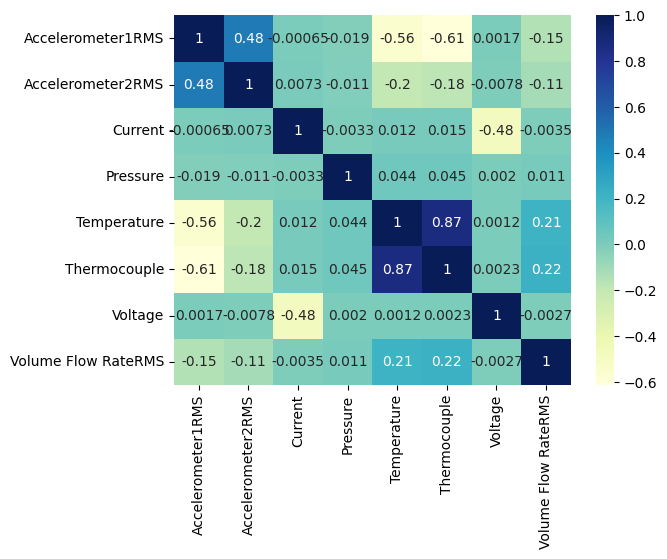

In [24]:
corr_plot = sns.heatmap(valve1_X.corr(), cmap="YlGnBu", annot=True) 
plt.show()

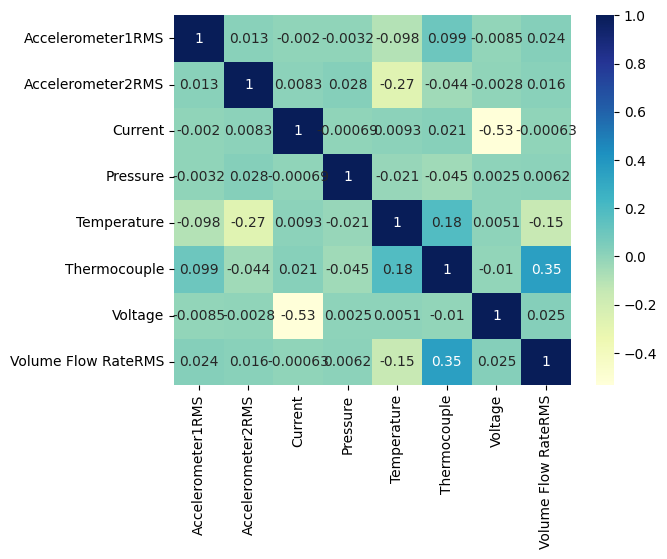

In [25]:
corr_plot = sns.heatmap(valve2_X.corr(), cmap="YlGnBu", annot=True) 
plt.show()

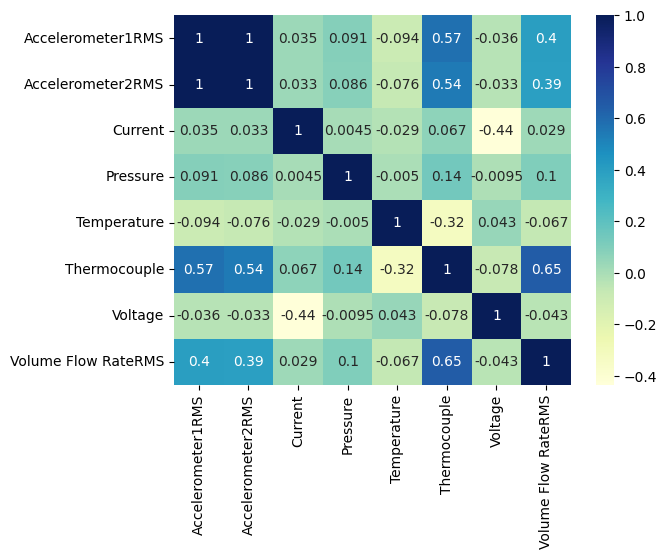

In [26]:
corr_plot = sns.heatmap(other_anomaly_X.corr(), cmap="YlGnBu", annot=True) 
plt.show()

__Drop duplicates__

In [27]:
print(f'valve 1 dataset shape: {valve1_X.shape}')
print(f'valve 2 dataset shape: {valve2_X.shape}')
print(f'other anomalies dataset shape: {other_anomaly_X.shape}')

valve1_duplicates = valve1_X.duplicated()
valve1_X = valve1_X.loc[~valve1_duplicates, :]
valve1_y = valve1_y.loc[~valve1_duplicates, :]

valve2_duplicates = valve2_X.duplicated()
valve2_X = valve2_X.loc[~valve2_duplicates, :]
valve2_y = valve2_y.loc[~valve2_duplicates, :]

other_anomaly_duplicates = other_anomaly_X.duplicated()
other_anomaly_X = other_anomaly_X.loc[~other_anomaly_duplicates, :]
other_anomaly_y = other_anomaly_y.loc[~other_anomaly_duplicates, :]

print('********************* Drop Duplicates *********************')
print(f'valve 1 dataset shape: {valve1_X.shape}')
print(f'valve 2 dataset shape: {valve2_X.shape}')
print(f'other anomalies dataset shape: {other_anomaly_X.shape}')

valve 1 dataset shape: (18162, 8)
valve 2 dataset shape: (4312, 8)
other anomalies dataset shape: (14985, 8)
********************* Drop Duplicates *********************
valve 1 dataset shape: (18162, 8)
valve 2 dataset shape: (4312, 8)
other anomalies dataset shape: (14542, 8)


__Winsorizer__

In [28]:
wz = Winsorizer(capping_method='quantiles', tail='both', fold=3)

In [29]:
# valve1_X = wz.fit_transform(valve1_X)
# valve2_X = wz.fit_transform(valve2_X)
# other_anomaly_X = wz.fit_transform(other_anomaly_X)

__Standard scaler__

In [30]:
sc = StandardScaler()

In [31]:
valve1_X = sc.fit_transform(valve1_X)
valve2_X = sc.fit_transform(valve2_X)
other_anomaly_X = sc.fit_transform(other_anomaly_X)

__PCA__

In [32]:
pca = PCA(n_components='mle', svd_solver='full')

In [33]:
# valve1_X = pca.fit_transform(valve1_X)
# valve2_X = pca.fit_transform(valve2_X)
# other_anomaly_X = pca.fit_transform(other_anomaly_X)

__RFE based on SVM__

In [34]:
estimator = SVR(kernel="linear")
rfe = RFE(estimator, n_features_to_select=5, step=1)

In [35]:
# valve1_X = rfe.fit_transform(valve1_X, valve1_y.anomaly)
# valve2_X = rfe.fit_transform(valve2_X, valve2_y.anomaly)
# other_anomaly_X = rfe.fit_transform(other_anomaly_X, other_anomaly_y.anomaly)

__Feature selection by single feature performance using random forest estimator__

In [36]:
sfp = SelectBySingleFeaturePerformance(
                    RandomForestClassifier(random_state=42),
                    cv=2)

In [37]:
# valve1_X = sfp.fit_transform(valve1_X, valve1_y.anomaly)
# valve2_X = sfp.fit_transform(valve2_X, valve2_y.anomaly)
# other_anomaly_X = sfp.fit_transform(other_anomaly_X, other_anomaly_y.anomaly)

__Feature selection by information value__

In [38]:
rfa = RecursiveFeatureAddition(RandomForestClassifier(random_state=42), cv=2)

In [39]:
# valve1_X = rfa.fit_transform(valve1_X, valve1_y.anomaly)
# valve2_X = rfa.fit_transform(valve2_X, valve2_y.anomaly)
# other_anomaly_X = rfa.fit_transform(other_anomaly_X, other_anomaly_y.anomaly)

__Smart correlated features__

In [40]:
scs = SmartCorrelatedSelection(threshold=0.8)

In [41]:
# # print(f'valve 1 dataset number of columns: {len(valve1_X.columns)}')
# # print(f'valve 2 dataset number of columns: {len(valve2_X.columns)}')
# # print(f'other animalies dataset number of columns: {len(other_anomaly_X.columns)}')

# valve1_X = scs.fit_transform(valve1_X)
# valve2_X = scs.fit_transform(valve2_X)
# other_anomaly_X = scs.fit_transform(other_anomaly_X)

# # print('********************* Drop correlated columns *********************')
# # print(f'valve 1 dataset number of columns: {len(valve1_X.columns)}')
# # print(f'valve 2 dataset number of columns: {len(valve2_X.columns)}')
# # print(f'other animalies dataset number of columns: {len(other_anomaly_X.columns)}')

## Retest models
#### Test model for valve 1

In [42]:
x_train, y_train, x_test, y_test = test_train_split(valve1_X, valve1_y)
# x_train_steps, y_train_steps = split_sequences(np.array([row.values for i, row in x_train.iterrows()]), N_STEPS)
# x_test_steps, y_test_steps = split_sequences(np.array([row.values for i, row in x_test.iterrows()]), N_STEPS)
x_train_steps, y_train_steps = split_sequences(x_train, N_STEPS)
x_test_steps, y_test_steps = split_sequences(x_test, N_STEPS)

model.fit(x_train_steps,y_train_steps)

# results predicting
residuals_train = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
UCL = residuals_train.quantile(Q)

454/454 [==============================] - 1s 2ms/step


In [43]:
# results predicting
# lstm_residuals = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
# yhat_train = pd.Series((lstm_residuals > UCL).astype(int).values, 
#                             index=x_train[N_STEPS:].index).fillna(0)

# lstm_residuals = pd.DataFrame(y_test_steps - model.predict(x_test_steps)).abs().sum(axis=1)
# yhat_test = pd.Series((lstm_residuals > UCL).astype(int).values, 
#                             index=x_test[N_STEPS:].index).fillna(0)

lstm_residuals = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
yhat_train = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=np.arange(len(x_train[N_STEPS:]))).fillna(0)

lstm_residuals = pd.DataFrame(y_test_steps - model.predict(x_test_steps)).abs().sum(axis=1)
yhat_test = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=np.arange(len(x_test[N_STEPS:]))).fillna(0)

114/114 [==============================] - 0s 2ms/step


In [44]:
print('Training accuracy {:.4f}'.format(accuracy_score(y_train[N_STEPS:],yhat_train)))
print('Testing accuracy {:.4f}'.format(accuracy_score(y_test[N_STEPS:],yhat_test)))

Training accuracy 0.6490
Testing accuracy 0.7398


In [45]:
accuracy = accuracy_score(y_test[N_STEPS:],yhat_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test[N_STEPS:],yhat_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test[N_STEPS:],yhat_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test[N_STEPS:],yhat_test)
print('F1 score: %f' % f1)

Accuracy: 0.739802
Precision: 0.861111
Recall: 0.277236
F1 score: 0.419434


In [46]:
conf_matrix = metrics.confusion_matrix(y_test[N_STEPS:],yhat_test)

TN, FP, FN, TP = conf_matrix.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate FAR false alarm rate
FPR = FP/(FP+TN)
# False negative rate MAR missing alarm rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(f'False Alarm Rate: {FPR}')
print(f'Missing Alarm Rate: {FNR}')

False Alarm Rate: 0.022935779816513763
Missing Alarm Rate: 0.7227642276422764


In [47]:
print(metrics.classification_report(y_test[N_STEPS:],yhat_test))

              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83      2398
         1.0       0.86      0.28      0.42      1230

    accuracy                           0.74      3628
   macro avg       0.79      0.63      0.63      3628
weighted avg       0.77      0.74      0.69      3628



#### Test model for valve 2

In [48]:
x_train, y_train, x_test, y_test = test_train_split(valve2_X, valve2_y)
# x_train_steps, y_train_steps = split_sequences(np.array([row.values for i, row in x_train.iterrows()]), N_STEPS)
# x_test_steps, y_test_steps = split_sequences(np.array([row.values for i, row in x_test.iterrows()]), N_STEPS)
x_train_steps, y_train_steps = split_sequences(x_train, N_STEPS)
x_test_steps, y_test_steps = split_sequences(x_test, N_STEPS)

model.fit(x_train_steps,y_train_steps)

# results predicting
residuals_train = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
UCL = residuals_train.quantile(Q)

108/108 [==============================] - 0s 2ms/step


In [49]:
# # results predicting
# lstm_residuals = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
# yhat_train = pd.Series((lstm_residuals > UCL).astype(int).values, 
#                             index=x_train[N_STEPS:].index).fillna(0)

# lstm_residuals = pd.DataFrame(y_test_steps - model.predict(x_test_steps)).abs().sum(axis=1)
# yhat_test = pd.Series((lstm_residuals > UCL).astype(int).values, 
#                             index=x_test[N_STEPS:].index).fillna(0)

lstm_residuals = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
yhat_train = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=np.arange(len(x_train[N_STEPS:]))).fillna(0)

lstm_residuals = pd.DataFrame(y_test_steps - model.predict(x_test_steps)).abs().sum(axis=1)
yhat_test = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=np.arange(len(x_test[N_STEPS:]))).fillna(0)

27/27 [==============================] - 0s 2ms/step


In [50]:
print('Training accuracy {:.4f}'.format(accuracy_score(y_train[N_STEPS:],yhat_train)))
print('Testing accuracy {:.4f}'.format(accuracy_score(y_test[N_STEPS:],yhat_test)))

Training accuracy 0.6774
Testing accuracy 0.6946


In [51]:
accuracy = accuracy_score(y_test[N_STEPS:],yhat_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test[N_STEPS:],yhat_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test[N_STEPS:],yhat_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test[N_STEPS:],yhat_test)
print('F1 score: %f' % f1)

Accuracy: 0.694639
Precision: 0.806452
Recall: 0.443038
F1 score: 0.571895


In [52]:
conf_matrix = metrics.confusion_matrix(y_test[N_STEPS:],yhat_test)

TN, FP, FN, TP = conf_matrix.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate FAR false alarm rate
FPR = FP/(FP+TN)
# False negative rate MAR missing alarm rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(f'False Alarm Rate: {FPR}')
print(f'Missing Alarm Rate: {FNR}')

False Alarm Rate: 0.09071274298056156
Missing Alarm Rate: 0.5569620253164557


In [53]:
print(metrics.classification_report(y_test[N_STEPS:],yhat_test))

              precision    recall  f1-score   support

         0.0       0.66      0.91      0.76       463
         1.0       0.81      0.44      0.57       395

    accuracy                           0.69       858
   macro avg       0.73      0.68      0.67       858
weighted avg       0.73      0.69      0.67       858



#### Test model for other anomalies

In [54]:
x_train, y_train, x_test, y_test = test_train_split(other_anomaly_X, other_anomaly_y)
# x_train_steps, y_train_steps = split_sequences(np.array([row.values for i, row in x_train.iterrows()]), N_STEPS)
# x_test_steps, y_test_steps = split_sequences(np.array([row.values for i, row in x_test.iterrows()]), N_STEPS)
x_train_steps, y_train_steps = split_sequences(x_train, N_STEPS)
x_test_steps, y_test_steps = split_sequences(x_test, N_STEPS)

model.fit(x_train_steps,y_train_steps)

# results predicting
residuals_train = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
UCL = residuals_train.quantile(Q)

364/364 [==============================] - 1s 1ms/step


In [55]:
# # results predicting
# lstm_residuals = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
# yhat_train = pd.Series((lstm_residuals > UCL).astype(int).values, 
#                             index=x_train[N_STEPS:].index).fillna(0)

# lstm_residuals = pd.DataFrame(y_test_steps - model.predict(x_test_steps)).abs().sum(axis=1)
# yhat_test = pd.Series((lstm_residuals > UCL).astype(int).values, 
#                             index=x_test[N_STEPS:].index).fillna(0)

lstm_residuals = pd.DataFrame(y_train_steps - model.predict(x_train_steps)).abs().sum(axis=1)
yhat_train = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=np.arange(len(x_train[N_STEPS:]))).fillna(0)

lstm_residuals = pd.DataFrame(y_test_steps - model.predict(x_test_steps)).abs().sum(axis=1)
yhat_test = pd.Series((lstm_residuals > UCL).astype(int).values, 
                            index=np.arange(len(x_test[N_STEPS:]))).fillna(0)

91/91 [==============================] - 0s 1ms/step


In [56]:
print('Training accuracy {:.4f}'.format(accuracy_score(y_train[N_STEPS:],yhat_train)))
print('Testing accuracy {:.4f}'.format(accuracy_score(y_test[N_STEPS:],yhat_test)))

Training accuracy 0.6493
Testing accuracy 0.5451


In [57]:
accuracy = accuracy_score(y_test[N_STEPS:],yhat_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test[N_STEPS:],yhat_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test[N_STEPS:],yhat_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test[N_STEPS:],yhat_test)
print('F1 score: %f' % f1)

Accuracy: 0.545110
Precision: 0.464646
Recall: 0.035008
F1 score: 0.065110


In [58]:
conf_matrix = metrics.confusion_matrix(y_test[N_STEPS:],yhat_test)

TN, FP, FN, TP = conf_matrix.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate FAR false alarm rate
FPR = FP/(FP+TN)
# False negative rate MAR missing alarm rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(f'False Alarm Rate: {FPR}')
print(f'Missing Alarm Rate: {FNR}')

False Alarm Rate: 0.03333333333333333
Missing Alarm Rate: 0.9649923896499238


In [59]:
print(metrics.classification_report(y_test[N_STEPS:],yhat_test))

              precision    recall  f1-score   support

         0.0       0.55      0.97      0.70      1590
         1.0       0.46      0.04      0.07      1314

    accuracy                           0.55      2904
   macro avg       0.51      0.50      0.38      2904
weighted avg       0.51      0.55      0.41      2904

